In [1]:
from Database import Database
import sys
# import multiprocessing as mp
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.distributions import chi2
from bioinfokit import analys, visuz
from scipy.stats import fisher_exact
import time
from scipy.special import factorial
import scipy.stats as stats
from scipy.stats import mannwhitneyu



from fisher import pvalue_npy
from scipy.stats import chi2_contingency
from scipy.stats import uniform, randint

In [2]:
colnames=['index', '#snps_b', 'chr', 'start_region', 'stop_region']
breast = pd.read_csv("D:/Hanze_Groningen/STAGE/R/PLOTS/kary/vs/before/1000_filter/breast_ALL_1000.tsv", sep='\t', header=None, names=colnames)
colnames=['index', '#snps_nb', 'chr', 'start_region', 'stop_region']
nonbreast = pd.read_csv("D:/Hanze_Groningen/STAGE/R/PLOTS/kary/vs/before/1000_filter/nonbreast_ALL_1000.tsv", sep='\t', header=None, names=colnames)
breast.sort_values(['chr', 'start_region'], inplace=True)
nonbreast.sort_values(['chr', 'start_region'], inplace=True)
merged_df = breast.merge(nonbreast, on=['chr', 'start_region', 'stop_region'], how='outer')
merged_df.drop(columns=['index_x', 'index_y'], inplace=True)
merged_df_2000 = merged_df.copy()
merged_df

,#snps_b,chr,start_region,stop_region,#snps_nb
0,0,chr1,1,1000,0
1,0,chr1,1001,2000,0
2,0,chr1,2001,3000,0
3,0,chr1,3001,4000,0
4,0,chr1,4001,5000,0
...,...,...,...,...,...
3095684,0,chrY,59369001,59370000,0
3095685,0,chrY,59370001,59371000,0
3095686,0,chrY,59371001,59372000,0
3095687,0,chrY,59372001,59373000,0


In [3]:
def chi_square_self(df, colname_b, colname_nb):
    df['counts_breast_plus'] = df[colname_b] + (1/286)
    df['counts_nonbreast_plus'] = df[colname_nb] + (1/1952)
    n = np.array([286, 1952])
    S = df[['counts_breast_plus', 'counts_nonbreast_plus']].to_numpy()
    f = n / n.sum()
    E1 = S.sum(axis=1)[:,None]*f
    C = (n-S)
    E2 = C.sum(axis=1)[:,None]*f
    D1 = ((E1-S)**2/E1).sum(axis=1)
    D2 = ((E2-C)/E2).sum(axis=1)
    X2 = D1 + D2
    #
    p_value_X2 = chi2.sf(X2,1)
    #
    log10_p_value = -np.log10(p_value_X2)
    log10_p_value
    #
    df['X2'] = X2
    df['p_value_X2'] = p_value_X2
    df['log10_p_value'] = log10_p_value
    #
    S_C = np.concatenate((S, C), axis=1)
    return df, S_C, n, S, C
    
    

In [4]:
def chi_square(S_C, df):
    start_time = time.perf_counter()

    p_value_X2_TEST = list()
    for index, value in enumerate(S_C):
        table = np.array([[value[0], value[2]], [value[1], value[3]]])
        stat, p, dof, expected = chi2_contingency(table)
        p_value_X2_TEST.append(p)
        if (index%100000) == 0:
            print(len(p_value_X2_TEST))
    print(len(p_value_X2_TEST))

    print("--- %s seconds ---" % (time.perf_counter() - start_time))
    df['p_value_X2_TEST'] = p_value_X2_TEST
    return df
    

In [5]:
def log2_fc(df, n, S):
    constant = np.log(n[0]) - np.log(n[1])
    log2_fc = (np.log(S[:, 0]) - np.log(S[:, 1]) - constant) / np.log(2)
    df['log2_fc'] = log2_fc # log2(FC)
    return df

In [6]:
def fisher_test(S_C, df):
    start_time = time.perf_counter()

    p_value_F = list()
    for index, value in enumerate(S_C):
        table = np.array([[value[0], value[2]], [value[1], value[3]]])
        oddsr, p = fisher_exact(table, alternative='two-sided')
        p_value_F.append(p)
        if (index%100000) == 0:
            print(len(p_value_F))
    print(len(p_value_F))

    print("--- %s seconds ---" % (time.perf_counter() - start_time))
    df['p_value_F'] = p_value_F
    return df

# split 1000

<AxesSubplot:>

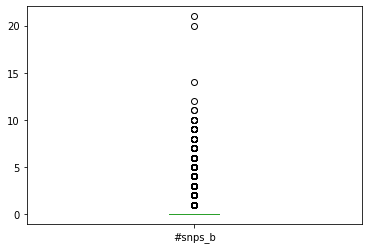

In [7]:
# https://www.reneshbedre.com/blog/mann-whitney-u-test.html
breast.boxplot(column=['#snps_b'], grid=False)

<AxesSubplot:>

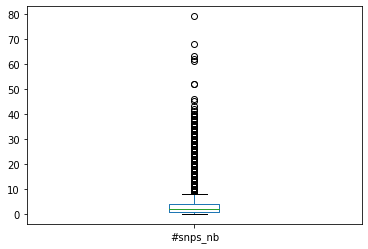

In [8]:
nonbreast.boxplot(column=['#snps_nb'], grid=False)

In [9]:
breast['filter_snps_b'] = breast['#snps_b']/ 286
nonbreast['filter_snps_nb'] = nonbreast['#snps_nb']/ 1952

C:\Users\Anne_\Anaconda3\envs\umap\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


w:0.45103782415390015, pvalue:0.0


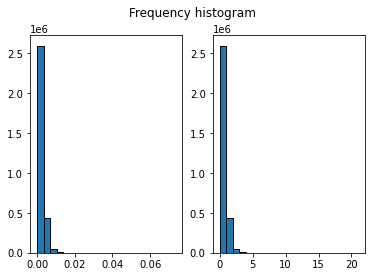

In [10]:
"""
As the p value obtained from the Shapiro-Wilk test is significant (p < 0.05), 
we conclude that the data is not normally distributed. Further, in histogram data 
distribution shape does not look normal. Therefore, Mann-Whitney U test is more appropriate for analyzing two samples.
"""
w, pvalue = stats.shapiro(breast['#snps_b'])
print(f'w:{w}, pvalue:{pvalue}')
# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(breast['filter_snps_b'], bins=breast['#snps_b'].max(), histtype='bar', ec='k') 
ax2.hist(breast['#snps_b'], bins=breast['#snps_b'].max(), histtype='bar', ec='k') 
plt.show()

w:0.8885494470596313, pvalue:0.0


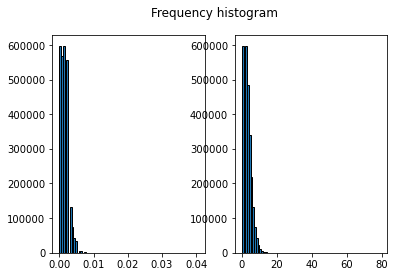

In [11]:
"""
As the p value obtained from the Shapiro-Wilk test is significant (p < 0.05), 
we conclude that the data is not normally distributed. Further, in histogram data 
distribution shape does not look normal. Therefore, Mann-Whitney U test is more appropriate for analyzing two samples.
"""
w, pvalue = stats.shapiro(nonbreast['#snps_nb'])
print(f'w:{w}, pvalue:{pvalue}')
# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(nonbreast['filter_snps_nb'], bins=nonbreast['#snps_nb'].max(), histtype='bar', ec='k') 
ax2.hist(nonbreast['#snps_nb'], bins=nonbreast['#snps_nb'].max(), histtype='bar', ec='k') 
plt.show()

In [12]:
"""
Mann-Whitney U test interpretation: As the p value obtained from the Mann-Whitney U test 
is significant (U = 489.5, p < 0.05), we conclude that the yield of the two genotypes 
significantly different from each other .
"""
# U1, p = mannwhitneyu(list(breast['filter_snps']), list(nonbreast['filter_snps']), alternative = 'two-sided')
mannwhitneyu(list(breast['filter_snps_b']), list(nonbreast['filter_snps_nb']), alternative = 'two-sided')


MannwhitneyuResult(statistic=2256239622468.0, pvalue=0.0)

In [ ]:
# """
# As the p value obtained from the Mann-Whitney U test is significant (U = 489.5, p < 0.05), 
# we conclude that the yield of the A genotype significantly greater than the genotype B.
# """
# stats.mannwhitneyu(list(breast['filter_snps_b']), list(nonbreast['filter_snps_nb']), alternative = 'greater')

In [ ]:
merged_df, S_C, n, S, C = chi_square_self(merged_df, '#snps_b', '#snps_nb')
merged_df = chi_square(S_C, merged_df)
merged_df = log2_fc(merged_df, n, S)
merged_df = fisher_test(S_C, merged_df)
merged_df = log2_fc(merged_df, n, S)
merged_df.to_csv(f"D:/Hanze_Groningen/STAGE/R/chrom_split_1000.tsv", sep='\t', encoding='utf-8', index=False)

1
100001
200001


In [ ]:
print(merged_df['p_value_F'].corr(merged_df['p_value_X2']))
print(merged_df['p_value_F'].corr(merged_df['p_value_X2_TEST']))

In [ ]:
plt = visuz.GeneExpression.volcano(df=merged_df,lfc='log2_fc',pv='p_value_X2',show=True)


In [ ]:
plt = visuz.GeneExpression.volcano(df=merged_df,lfc='log2_fc',pv='p_value_X2_TEST',show=True)


In [ ]:
plt = visuz.GeneExpression.volcano(df=merged_df,lfc='log2_fc',pv='p_value_F',show=True)


# 2000 spit

In [ ]:
merged_df_2000

In [ ]:
df = pd.DataFrame(columns=['#snps_b', 'chr', 'start_region', 'stop_region', '#snps_nb', 'snps_b_double', 'snps_nb_double'])

# chrom = ['chr4']
for i in list(set(merged_df_2000['chr'])):
    select_df = merged_df_2000[merged_df_2000['chr'] == i]
    select_df['snps_b_double'] = select_df['#snps_b'] + select_df['#snps_b'].shift(1)
    select_df['snps_nb_double'] = select_df['#snps_nb'] + select_df['#snps_nb'].shift(1)
    select_df['start_new'] = select_df['start_region'].shift(1) #.astype(str) #+ "_" + select_df['stop_region'].astype(str)
#     select_df['stop_new'] = select_df['stop_region']       
    select_df = select_df.reset_index()
    select_df.drop(columns=['index'], inplace=True)
    select_df = select_df.reset_index()
    select_df = select_df[(select_df['index'] % 2 != 0) | (select_df['index'] == select_df['index'].max())]
    select_df['start_new'] = list(select_df['start_new'][:-1])+[list(select_df['start_region'])[-1]]
    select_df.drop(columns=['index'], inplace=True)
#     select_df['stop_new'] = list(select_df['stop_new'][:-1])+[list(select_df['stop_region'])[-1]]
    df = pd.concat([df, select_df])


In [ ]:
df

In [ ]:
set(df['snps_b_double'])

In [ ]:
df[df['snps_b_double'].isnull()]

In [ ]:
# https://www.reneshbedre.com/blog/mann-whitney-u-test.html
df.boxplot(column=['snps_b_double'], grid=False)

In [ ]:
df.boxplot(column=['snps_nb_double'], grid=False)

In [ ]:
df['filter_snps_b'] = df['snps_b_double']/ 286
df['filter_snps_nb'] = df['snps_nb_double']/ 1952

In [ ]:
df

In [ ]:
"""
As the p value obtained from the Shapiro-Wilk test is significant (p < 0.05), 
we conclude that the data is not normally distributed. Further, in histogram data 
distribution shape does not look normal. Therefore, Mann-Whitney U test is more appropriate for analyzing two samples.
"""
w, pvalue = stats.shapiro(df['snps_b_double'])
print(f'w:{w}, pvalue:{pvalue}')
# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(df['filter_snps_b'], bins=int(df['snps_b_double'].max()), histtype='bar', ec='k') 
ax2.hist(df['snps_b_double'], bins=int(df['snps_b_double'].max()), histtype='bar', ec='k') 
plt.show()

In [ ]:
"""
As the p value obtained from the Shapiro-Wilk test is significant (p < 0.05), 
we conclude that the data is not normally distributed. Further, in histogram data 
distribution shape does not look normal. Therefore, Mann-Whitney U test is more appropriate for analyzing two samples.
"""
w, pvalue = stats.shapiro(df['snps_nb_double'])
print(f'w:{w}, pvalue:{pvalue}')
# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Frequency histogram')
ax1.hist(df['filter_snps_nb'], bins=int(df['snps_nb_double'].max()), histtype='bar', ec='k') 
ax2.hist(df['snps_nb_double'], bins=int(df['snps_nb_double'].max()), histtype='bar', ec='k') 
plt.show()

In [ ]:
"""
Mann-Whitney U test interpretation: As the p value obtained from the Mann-Whitney U test 
is significant (U = 489.5, p < 0.05), we conclude that the yield of the two genotypes 
significantly different from each other .
"""
# U1, p = mannwhitneyu(list(breast['filter_snps']), list(nonbreast['filter_snps']), alternative = 'two-sided')
mannwhitneyu(list(df['filter_snps_b']), list(df['filter_snps_nb']), alternative = 'two-sided')


In [ ]:
df, S_C, n, S, C = chi_square_self(df, 'snps_b_double', 'snps_b_double')
df = chi_square(S_C, df)
df = log2_fc(df, n, S)
df = fisher_test(S_C, df)
df = log2_fc(df, n, S)
df.to_csv(f"D:/Hanze_Groningen/STAGE/R/chrom_split_2000.tsv", sep='\t', encoding='utf-8', index=False)

In [ ]:
print(df['p_value_F'].corr(df['p_value_X2']))
print(df['p_value_F'].corr(df['p_value_X2_TEST']))

In [ ]:
plt = visuz.GeneExpression.volcano(df=df,lfc='log2_fc',pv='p_value_X2',show=True)


In [ ]:
plt = visuz.GeneExpression.volcano(df=df,lfc='log2_fc',pv='p_value_X2_TEST',show=True)


In [ ]:
plt = visuz.GeneExpression.volcano(df=df,lfc='log2_fc',pv='p_value_F',show=True)


In [ ]:
# print(merged_df['start_region'].max())
# print(merged_df['stop_region'].max())

In [ ]:
# test = merged_df[merged_df['#snps_b'] >2]

In [ ]:
# test['#snps_b_double'] = test['#snps_b'] + test['#snps_b'].shift(1)
# test

In [ ]:
# merged_df['next_chr'] = merged_df['chr'] != merged_df['chr'].shift(1)

In [ ]:
# df = pd.DataFrame(columns=['#snps_b', 'chr', 'start_region', 'stop_region', '#snps_nb', 'snps_b_double', 'snps_nb_double'])

# # chrom = ['chr1', 'chr2', 'chr3']
# for i in list(set(merged_df['chr'])):
#     select_df = merged_df[merged_df['chr'] == i]
#     select_df['snps_b_double'] = select_df['#snps_b'] + select_df['#snps_b'].shift(1)
#     select_df['snps_nb_double'] = select_df['#snps_nb'] + select_df['#snps_nb'].shift(1)
#     select_df['start_new'] = select_df['start_region'].shift(1) #.astype(str) #+ "_" + select_df['stop_region'].astype(str)
# #     select_df['stop_new'] = select_df['stop_region']       
#     select_df = select_df.reset_index()   
#     select_df = select_df[(~select_df['index'] % 2 == 0) | (select_df['index'] == select_df['index'].max())]
#     select_df['start_new'] = list(select_df['start_new'][:-1])+[list(select_df['start_region'])[-1]]
#     select_df.drop(columns=['index'], inplace=True)
# #     select_df['stop_new'] = list(select_df['stop_new'][:-1])+[list(select_df['stop_region'])[-1]]
#     df = pd.concat([df, select_df])


In [ ]:
df